To do:
* deal with dependencies -- either show include a command for installing the libraries required to run this notebook (e.g. `pip install matplotlib pandas opencv-python ultralytics...`) or use runtime environment

![spacecraft with bounding box](https://drivendata-public-assets.s3.amazonaws.com/nasa-spacecraft-leading-example.jpg)

Welcome to the benchmark notebook for the **Pose Bowl: Object Detection** challenge!

If you are just getting started, first checkout the competition [homepage](https://www.drivendata.org/competitions/260/spacecraft-detection/) and [problem description](https://www.drivendata.org/competitions/260/spacecraft-detection/page/833/).

## Pose Bowl: Object Detection

In this challenge, you will help to develop new methods for conducting spacecraft inspections by identifying the position and orientation of a target spacecraft in an image.

The goal of this $12,000 challenge is to help NASA address key operational hurdles in spacecraft inspection, including the ability to detect a variety of different types of target spacecraft, as well as being able to run this code efficiently on relatively low-cost hardware. For the latter reason, this challenge is a **code execution challenge**, and your submission will be run on our code execution platform in an environment that simulates a small, [off-the-shelf computer board](https://www.aaeon.com/en/p/up-board-computer-board-for-professional-makers) used on [R5 NASA spacecraft](https://ntrs.nasa.gov/api/citations/20230011368/downloads/R5_Fact_Sheet_2023-07.pdf).

If you're not familiar with code execution challenges, don't be intimidated. This benchmark notebook / blog post is all you need to get comfortable with the setup and on your way to producing your own challenge submissions.

We'll cover two main areas in this post:

- [**Section 1. Data exploration:**](#data-exploration): An introduction to the spacecraft images dataset, including image examples and some explanation about the type of variation to expect across the dataset.

- [**Section 2. Demo submission:**](#demo-submission) A demonstration of how to run the benchmark example and produce a valid code submission.

<a id="data-exploration"></a>

## Section 1: Getting started

### Get this notebook

First, clone the runtime repository with:
```
git clone https://github.com/drivendataorg/spacecraft-pose-object-detection-runtime.git
```

The repository includes a copy of this notebook in `/notebooks/data-exploration-and-benchmark.ipynb`. We'd encourage you to run this notebook yourself as part of this exercise.

### Download some data

The runtime repository should already have copies of several CSV files that you'll need in developing your solution.

It does _not_ contain the imagery dataset, which you'll have to download yourself due to its large size. The simplest way to download the images is using the [AWS CLI](https://aws.amazon.com/cli/). For more detailed instructions, see the `data_download_instructions.txt` file on the [Data Download](https://www.drivendata.org/competitions/260/spacecraft-detection/data/) page.

The imagery dataset comes in the form of `.tar` files, each of which is about 10GB. There are (tktk) of these files available. To get started, let's just download one of these with an AWS CLI command like this:

```
aws s3 cp s3://drivendata-competition-spacepose-public-us/images/0.tar ./ --no-sign-request
```

This may take some time, so if you're not into vigilantly monitoring the progress of your download, feel free to do something else for a little while.

Once the tar file has been downloaded, you can extract it to the `data_dev` directory (the command below should work on a Unix-based system). We suggest saving the images to the `data_dev` directory (or something similarly named) rather than the `data` directory because the `data` directory plays a special role in simulating the test data that is available when your submission runs in the code execution environment.
```
tar -xzvf 0.tar.gz -C data_dev/
```
(tktk: double check AWS CLI and tar commands once we have final data on S3)

Once everything is downloaded, your `data_dev` directory should look like this.
```
spacecraft-pose-object-detection-runtime/
└── data_dev
    ├── images
    │   ├── 0002541eda1eec0e3f6e82f113330328.png
    │   ├── 0002761db291101c32b1147aa53d9d9d.png
    │   ├── 000337082008a61da968ab9be4a373a9.png
    │   ...
    │
    ├── submission_format.csv
    ├── train_labels.csv
    └── train_metadata.csv
```

### Explore the data

In [1]:
from pathlib import Path
import pandas as pd

PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY = DEV_DIRECTORY / "images"

/var/folders/z_/8ldqtv294hl5py94q90x13v80000gn/T/ipykernel_36814/2377376609.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


First, let's take a look at two of the metadata files.

In [2]:
train_meta = pd.read_csv(DEV_DIRECTORY / "train_metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")

The `train_meta` CSV contains information about the type of spacecraft and background used to generate the image. You should consider ways to use this information effectively in stratifying your train and test splits. The test data that you will be evaluated on includes spacecraft types that are not included in the training set, so you will want to consider strategies for ensuring your model generalizes well.

The `train_meta` CSV contains information about all images in the training set. But since we haven't downloaded all the images yet, let's filter the dataset down to just the images we've saved locally.

In [3]:
# we didn't download the full training set, so add a column indicating which images are saved locally
train_meta["exists"] = train_meta.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())
# filter our metadata down to only the images we have locally
train_meta = train_meta[train_meta.exists]

train_meta.head()

,spacecraft_id,background_id,exists
image_id,,,
0002541eda1eec0e3f6e82f113330328,6,9,True
0002761db291101c32b1147aa53d9d9d,13,5,True
000337082008a61da968ab9be4a373a9,6,13,True
000564e3d5164e09191ea02def174d64,18,5,True
0005a3fec98c43a5a84e4b1933a44387,19,17,True


The `train_labels` CSV contains the bounding box information for the target spacecraft in each image.

In [4]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0000f96cf3bb9bb4df123741eedeca66,66,43,120,101
000121ebfd3929763852976c4f34cffc,615,6,1280,162
0001b016f562cdeee654504b23cc9ffd,748,283,1280,1024
0002541eda1eec0e3f6e82f113330328,899,0,1049,106
0002761db291101c32b1147aa53d9d9d,291,750,301,760


Let's look at a few example images to get a feel for what's in this dataset.

In [5]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def get_bbox(image_id, labels):
    """To do: update to use final metadata file"""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.tolist()

def display_image(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=train_labels):
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    ax.imshow(img)

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

Some images are relatively straightforward with an easily identified spacecraft. Below is one example. Note that the spacecraft is not necessarily fully in view. Also note that the background in this case consists entirely of our planet, with no view of outer space, while in other images it may be entirely space, or more commonly a mix of planet and space.

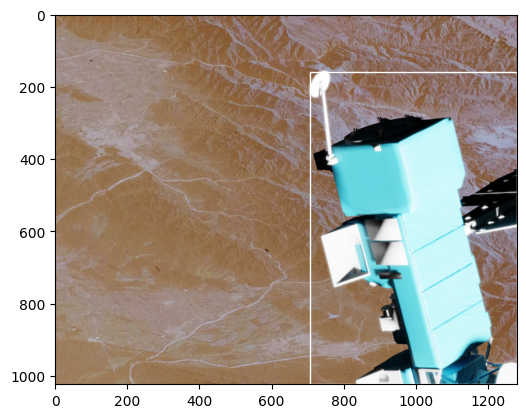

In [6]:
display_image("003e752f698dbc6d3ff18a17ab446cb4", show_bbox=True)

There are also many other examples where the spacecraft will be more difficult to detect.

One challenging type of image involves target spacecraft that appear very small, due to their distance from the chaser spacecraft. Here is one example of that situation, made particularly difficult by image blur.

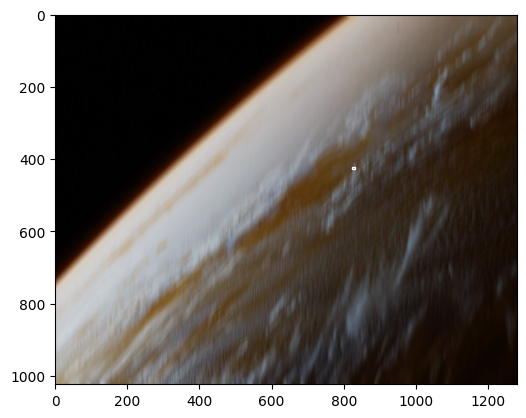

In [7]:
display_image("00e799ac4c9f98b0fd5a6529d76de4e3", show_bbox=True)

Lens flare and other visual artifacts from the refraction of light on the camera lens may also complicate your detection algorithm, as in the example below.

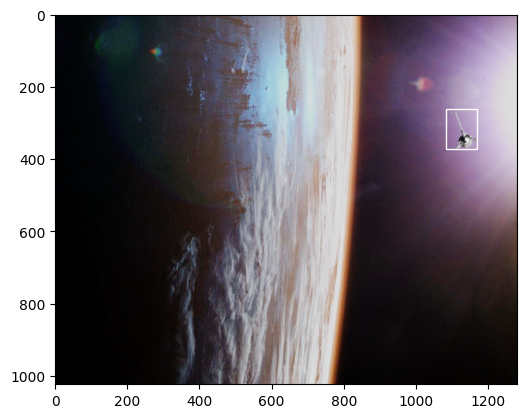

In [8]:
display_image("00475833efb961c897ed222b077698ed", show_bbox=True)

Some target spacecraft may have long, thin appendages that are difficult or even impossible to see. Remember that your bounding box needs to encompass these appendages.

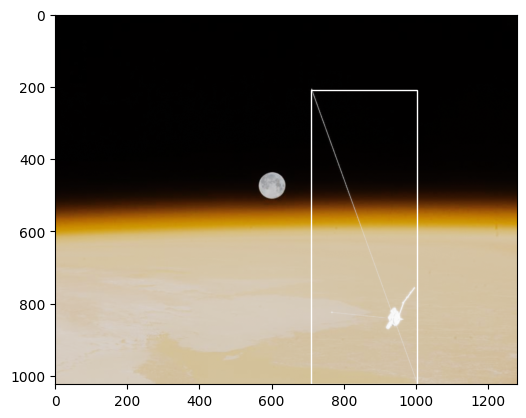

In [9]:
display_image("00a257cb17325152e35c0ccd17e3ad51", show_bbox=True)

Finally, there will be situations where parts of the spacecraft are obscured by shadow. This can make it particularly difficult to detect the edges of thin appendages like the ones we saw above.

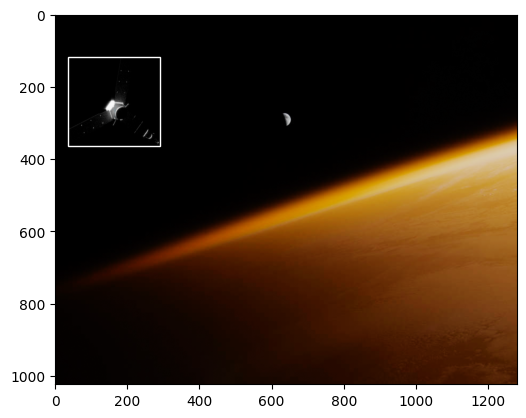

In [10]:
display_image("007c84c2fdf6f9d7fd71d38b6ed4a5b4", show_bbox=True)

(tktk remove these notes)
* Relatively easy to identify spacecraft on Earth background (002f21e84cc706fd78fe8d8e19daeade, 00fead11ed0095d30a4bd4cff32a3ed0, 00e1537669a223d1a2dc6ece7e9a3565)
* Light artifacts (0023475e453a38131cc89eceabde03fa, 00475833efb961c897ed222b077698ed)
* Spacecraft with long, thin appendages (00a257cb17325152e35c0ccd17e3ad51, 005e3b4ed4ea0e9f4f14d57c42d0f068)
* Spacecraft in shadow (005665dc921bc8e307b96cfc1a2fcd28, 00e1537669a223d1a2dc6ece7e9a3565)
* Very small spacecraft (00e799ac4c9f98b0fd5a6529d76de4e3)

Explore for yourself

The code below will pull and display a random image. Feel free to run this as many times as you like to develop your intuition for what types of images are in this dataset.

0098f547067540fba1fd709ea66490cb


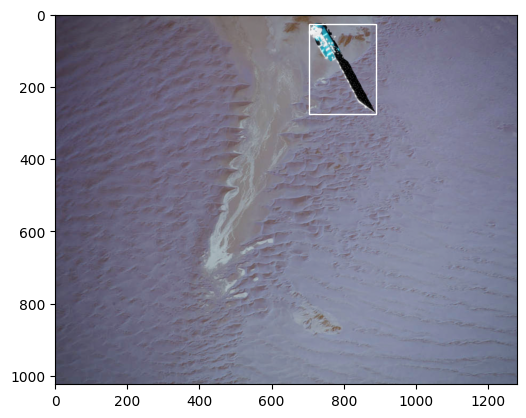

In [11]:
image_id = train_meta.sample(1).index[0]
print(image_id)

ax = display_image(image_id, show_bbox=True)

<a id="demo-submission"></a>

## Section 2: Demo submission
Now that we've had a chance to get familiar with the data, it's time to walk through the steps for creating a competition submission.

This is a **code submission competition**, so our focus for now will be on creating that submission in the correct format, and less so on the accuracy of the predictions.

If you haven't already read through the following resources, now would be a great time to do that:
* [Code Submission Format page](https://www.drivendata.org/competitions/260/spacecraft-detection/page/835/): An introduction to the code submission setup and how to make a valid submission.
* [Runtime Repository README](https://github.com/drivendataorg/spacecraft-pose-object-detection-runtime): Details on the competition runtime and how to use this repository effectively.

Using the `/data` directory

The `/data` directory in this runtime repository plays two important roles:

* When you are testing your solution locally, the contents of `/data` will be mounted on the Docker container that simulates our code execution platform (further below, we'll walk through the specifics of how to do these test runs)
* When you make a submission on the DrivenData platform, the contents of `/data` that get mounted to the Docker container will be the unseen test data that ultimately determines your rank on the leaderboard.

To develop your submission locally, you should add a subset of the challenge data to `/data` and treat this as your local validation or test set.

We'll demonstrate one way to do that next...

First, let's select a subset of 100 images in `/data_dev` to treat as our validation set.

In [22]:
val_images = train_meta.sample(100, random_state=1).index.tolist()
val_images[:5]

['0036da22a5986077cdda0abee829f5a5',
 '00475833efb961c897ed222b077698ed',
 '0019863919febf855e372f834b42e98b',
 '00a37cf1a6c4c2a74f6c0b5ad78897d4',
 '0093dbd458fc4b1e95a4bd3eb46b763e']

Next, we'll move these files into the `/data` directory.

In [23]:
import shutil

for img in val_images:
    shutil.copy2(IMAGES_DIRECTORY / f"{img}.png", DATA_DIRECTORY / "images" / f"{img}.png")

Next we'll add a "submission format" files to `/data`.

> Note: A submission format file in this case is simply a CSV that has the correct column and row indices required for a valid submission. Using this type of standard file is a useful way to ensure that all participants understand how their submission needs to be formatted in order to be accepted, and we tend to use these in most of our challenges.

A submission format file for the full training set is already present in `/data_dev`. We'll make a copy of this that only includes rows pertaining to the images in our validation set, and save it in `/data`.

In [24]:
submission_format = pd.read_csv(DEV_DIRECTORY / "submission_format.csv", index_col="image_id")
submission_format_val = submission_format.loc[val_images]
submission_format_val.to_csv(DATA_DIRECTORY / "submission_format.csv")

### Download a pretrained model

For this benchmark example, we will rely on YOLO, a commonly used algorithm for object detection. This will suit our purposes for demonstrating a very basic baseline approach, but you should explore more sophisticated methods yourself.

To download the latest v8 YOLO model, we'll use the `ultralytics` library. The code below will download the model and move it into the `example_benchmark` directory, where we're assembling our submission.

In [31]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
shutil.move('yolov8n.pt', PROJ_DIRECTORY / "example_benchmark")

100%|██████████| 6.23M/6.23M [00:00<00:00, 7.93MB/s]


'/Users/mschlauch/dd/spacecraft-pose-object-detection-runtime/example_benchmark/yolov8n.pt'

### Three Commands
To run and test the benchmark example, you just need to execute the following 3 commands:

1. [`make pull`](#make-pull)
2. [`make pack-benchmark`](#make-pack-benchmark)
3. [`make test-submission`](#make-test-submission)

These are defined in the project `Makefile` [here](https://github.com/drivendataorg/spacecraft-pose-object-detection-runtime/blob/main/Makefile). We'll walk through what each one does now.

<a id="make-pull"></a>

#### **`make pull`**

To ensure that all participants are using the same runtime environment, we have a publicly accessible docker image hosted on [Azure Container Registry](https://azure.microsoft.com/en-us/services/container-registry/).

The `make pull` command pulls the official version of the docker image and stores it locally. Having a local version of the competition image allows you to test your submission using the same image that is used during code execution.

> **Note:** This command can take a little while to run the first time you pull the image. But after that it will be relatively quick since you'll have all the layers cached locally.

In [33]:
# authentication required -- need to `az login` until container registry is made public
# !cd {PROJ_DIRECTORY} && make pull

You should now have a local copy of the docker image, which you can verify by running:

In [34]:
!docker images

REPOSITORY                                                   TAG       IMAGE ID       CREATED       SIZE
spacecraft-pose-object-detection                             local     523c7e362745   2 hours ago   5.04GB
<none>                                                       <none>    1ead733d2921   7 hours ago   4.79GB
spacecraftpose.azurecr.io/spacecraft-pose-object-detection   latest    0716693748ee   7 days ago    4.78GB


<a id="make-pack-benchmark"></a>

#### **`make pack-benchmark`** 
This command simply goes to your `benchmark_src` directory, zips the contents, and writes the zip archive to `submission/submission.zip`.

Since we already downloaded a model above, the `benchmark_src` directory should look like this:
```
spacecraft-pose-object-detection-runtime/
└── benchmark_src/
    ├── main.py
    ├── main.sh
    └── yolov8n.pt
```

In [36]:
!cd {PROJ_DIRECTORY} && make pack-benchmark

mkdir -p submission/
cd example_benchmark; zip -r ../submission/submission.zip ./*
  adding: main.py (deflated 58%)
  adding: main.sh (deflated 26%)
  adding: yolov8n.pt (deflated 9%)


> **Note:** The `make pack-benchmark` command will check to see if you already have a `submission/submission.zip` and error if you do, so as not to overwrite existing work. If you already have this file, you'll need to manually remove it before running the command.

After running the above command, we should now have a new **`submission/submission.zip`**.
```
boem-belugas-runtime/
├── benchmark_src/
│   ├── main.py
│   ├── main.sh
│   └── yolov8n.pt
└── submission/
    └── submission.zip   <---- new file, this is what gets submitted on platform
```

This is the file that we will eventually upload to the competition platform for code execution, but before doing that, we want to test it locally.

<a id="make-test-submission"></a>

#### **`make test-submission`** 
This command simulates what happens during actual code execution, launching an instance of the official Docker image and running the same inference process that runs on the competition platform. The required host directories are mounted on the container, and the entrypoint script `main.sh` is executed.

In [37]:
!cd {PROJ_DIRECTORY} && make test-submission

mkdir -p submission/
chmod -R 0777 submission/
docker run \
		-it --network none \
		--mount type=bind,source="/Users/mschlauch/dd/spacecraft-pose-object-detection-runtime"/data,target=/code_execution/data,readonly \
		--mount type=bind,source="/Users/mschlauch/dd/spacecraft-pose-object-detection-runtime"/submission,target=/code_execution/submission \
		--shm-size 8g \
		--name spacecraft-pose-object-detection \
		--rm \
		523c7e362745
+ main
+ tee /code_execution/submission/log.txt
+ cd /code_execution
+ curl --silent --connect-timeout 10 --max-time 12 www.example.com
+ data_directory=/code_execution/data
+ format_filename=/code_execution/data/submission_format.csv
+ (( i=0 ))
+ (( i<=5 ))
+ t=0
+ '[' -f /code_execution/data/submission_format.csv ']'
+ echo 'found /code_execution/data/submission_format.csv after 0 seconds; data is mounted'
found /code_execution/data/submission_format.csv after 0 seconds; data is mounted
+ break
+ '[' '!' -f /code_execution/data/submission_format.csv '

### Submitting to the platform
We're almost done. Assuming that our test run completed and the `submission.csv` looks correct, it's time to submit the code on the platform.

* Go to the [competition submissions page](https://www.drivendata.org/competitions/260/spacecraft-detection/submissions/) and upload your `submission/submission.zip`.
* Please be patient while your submission is uploaded and executed. Your job may be queued if other jobs are still pending.
* You can track the status of your submission on the [Code Execution Status](https://www.drivendata.org/competitions/260/submissions/code/) page. Logs will become available once the submission begins processing. To see them click on "View Logs".
* Submissions have up to 3 hours to complete. Again, please be patient.

If code execution completes successfully, you will see something like this on the [Code Execution Status](https://www.drivendata.org/competitions/260/submissions/code/) page:

![code execution completed](tktk)

First, celebrate a little bit if you feel like it 🎉. This is an achievement in itself!

But you're probably more interested in knowing the mAP score that determines your place on the public leaderboard. Go over to the [Submissions](https://www.drivendata.org/competitions/260/spacecraft-detection/submissions/) page where you'll see something like this, except that we're sure you can do better than the benchmark!

![score](tktk)

**That's it! You're on your way to creating your own code submission and helping to protect endangered beluga whale populations with machine learning.**

**Head over to the [competition](https://www.drivendata.org/competitions/260/spacecraft-detection/) homepage to get started. And have fun! We can't wait to see what you build!**

_Photos courtesy of [NASA](tktk)._